In [1]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_steane
from encoded.LST import int_to_binary

## Computer parameters

In [2]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85]
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [3]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 1)

## Analog version

In [4]:


n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()


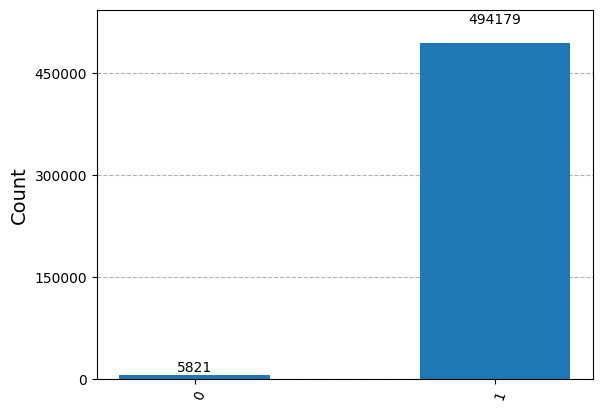

In [5]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [6]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  98.83579999999999 %


## Encoding the Steane code (k = 2)

In [12]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1

# Steane codewords (you can get them by simulating the dj_steane without noise)
logical_1_codeword = ["1110000","0101010","1000110","0100101","0010011","1001001","1111111","0011100"]
logical_0_codeword = ["1011010","0001111","0000000","0110110","1101100","1010101","0111001","1100011"]


k = 2
qreg = cirq.LineQubit.range(7*k)
circuit= dj_steane(qreg,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:7*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    #initial_layout=layout[7],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


OrderedDict([('rz', 243),
             ('sx', 135),
             ('ecr', 67),
             ('reset', 14),
             ('x', 11),
             ('measure', 7)])

In [13]:
compiled_raw.draw(fold = -1)

global phase: 0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
    ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                              

In [14]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

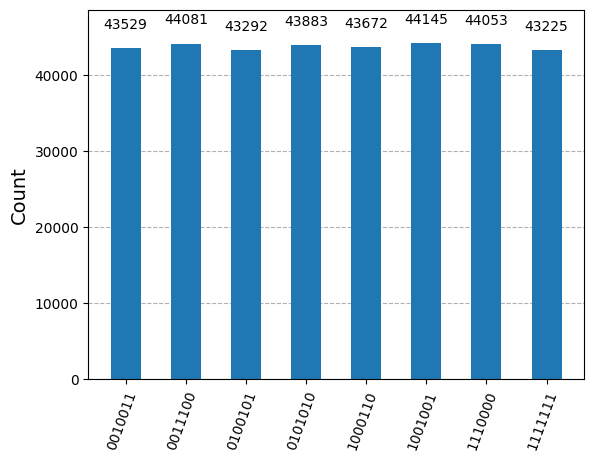

In [16]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

### Using the encoding to take into account only the logical errors

In [17]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  99.64485784345834 %


# TeST

In [3]:
def encoding_steane(qreg) -> cirq.Circuit:
    circuit = cirq.Circuit()
    circuit = cirq.Circuit()

    circuit.append(cirq.H.on(qreg[0]))
    circuit.append(cirq.H.on(qreg[4]))
    circuit.append(cirq.H.on(qreg[6]))

    circuit.append(cirq.CNOT.on(qreg[0], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[5]))

    circuit.append(cirq.CNOT.on(qreg[6], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[6], qreg[5]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[2]))

    circuit.append(cirq.CNOT.on(qreg[0], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[3], qreg[2]))

    return circuit

In [4]:
encoding_steane(cirq.LineQubit.range(7))

┌──┐   ┌──┐   ┌──┐
0: ───H────@───────@───────────
           │       │
1: ────────X───────┼─────X─────
                   │     │
2: ───────────────X┼─────┼X────
                  ││     ││
3: ─────────X─────┼X─────┼@────
            │     │      │
4: ───H────@┼─────@──────@─────
           ││
5: ────────X┼─────X────────────
            │     │
6: ───H─────@─────@────────────
          └──┘   └──┘   └──┘

In [ ]:
import stim
from typing import List

def parity_check_matrix_to_stabilizers(matrix: np.ndarray) -> List[stim.PauliString]:
    num_rows, num_cols = matrix.shape
    assert num_cols % 2 == 0
    num_qubits = num_cols // 2

    matrix = matrix.astype(np.bool8)  # indicate the data isn't bit packed
    return [
        stim.PauliString.from_numpy(
            xs=matrix[row, :num_qubits],
            zs=matrix[row, num_qubits:],
        )
        for row in range(num_rows)
    ]


def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )


    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')

In [ ]:
import itertools

a = stim.PauliString("+XXXX___")
b = stim.PauliString("+_XX_XX_")
c = stim.PauliString("+__XX_XX")
d = stim.PauliString("+ZZZZ___")
e = stim.PauliString("+_ZZ_ZZ_")
f = stim.PauliString("+__ZZ_ZZ")
stab_list = [a, b,c ,d ,e,f]

permutations_stab = list(itertools.permutations(stab_list))
for perm in permutations_stab:
    test_encoder = stabilizers_to_encoder(perm)
    print(test_encoder.diagram())
    print("#"+str(len(test_encoder)))
    print(perm)


        /---------------\
q0: -RX-@-@-@---------------
        | | |
q1: -RX-|-|-|-@-@-@---------
        | | | | | |
q2: -RX-|-|-|-|-|-|-@-@-@---
        | | | | | | | | |
q3: -RX-@-|-|-@-|-|-@-|-|-H-
          | |   | |   | |
q4: -RX---@-|---@-|---|-|-H-
            |     |   | |
q5: -RX-----@-----|---@-|-H-
                  |     |
q6: -RX-----------@-----@-H-
        \---------------/
#5
(stim.PauliString("+XXXX___"), stim.PauliString("+_XX_XX_"), stim.PauliString("+__XX_XX"), stim.PauliString("+ZZZZ___"), stim.PauliString("+_ZZ_ZZ_"), stim.PauliString("+__ZZ_ZZ"))
        /---------------\
q0: -RX-@-@-@---------------
        | | |
q1: -RX-|-|-|-@-@-@---------
        | | | | | |
q2: -RX-|-|-|-|-|-|-@-@-@---
        | | | | | | | | |
q3: -RX-@-|-|-@-|-|-@-|-|-H-
          | |   | |   | |
q4: -RX---@-|---@-|---|-|-H-
            |     |   | |
q5: -RX-----@-----|---@-|-H-
                  |     |
q6: -RX-----------@-----@-H-
        \---------------/
#5
(stim.PauliString("+XXXX___

5